# Introducción

La base de datos que vamos a utilizar recibe el nombre de HAM10000 y forma parte de un desafío planteado por un consorcio de investigación denominado ISIC (International Sking Imaging Collaboration) en un esfuerzo por tratar de desarrollar herramientas de diagnóstico de cánceres de piel basadas en diferentes técnicas de aprendizaje automático. Por si alguno estuviese interesado la referencia de la publicación en la que fue anunciada es:
 > Tschandl, P. _The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions_, 2018. doi: 10.7910/DVN.

La base de datos original cuenta con 10.015 imágenes de diferentes cánceres clasificados en 7 categorías por un equipo diverso y extenso de médicos especialistas. La base de datos incluye diferentes datos acerca del tipo de técnica empleada para el diagnóstico así como enfermedad relacionada con los pacientes (edad, sexo, etc.) que pueden ser muy interesantes ya que podrían servir como información complementaria que se podría suministrar a la red. 

Se trata de una base de datos compleja con varias idiosincrasias que comentarémos a lo largo de la práctica. El desafío se dio por completado en el 2018 y se han recogido los resultados en un artículo por Codella _et al._ (2018) cuya referencia se encuentra bajo el presente párrafo. En los resultados obtenidos se puede ver que las tasas de aciertos no superan el 85 % de aciertos, lo que nos permite observar cuán difícil es esta tarea.

> Codella, N., Rotemberg, V., Tschandl, P., Celebi, M. E., Dusza, S., Gutman, D., ... & Halpern, A. (2019). _Skin lesion analysis toward melanoma detection 2018: A challenge hosted by the international skin imaging collaboration (ISIC)_. arXiv preprint arXiv:1902.03368.

En nuestro caso, no disponemos ni de los recursos ni del tiempo necesarios para enfrentar un problema tan complejo de manera razonable. De manera que vamos a simplificar el desafío: nuestro objetivo no será clasificar las lesiones en las diferentes enfermedades subyacientes sino simplemente predecir si la lesión constituye un tumor benigno o maligno (un cáncer).

# Entrenamiento de la red neural




## Paso 1: Acceder a los datos

Primero cargamos una llave (`kaggle.json`) que nos va a permitir acceder al repsitorio donde se encuentra la base de datos con las fotos de cánceres de piel y sus diagnósticos. Para obtener vuestra propia llave podéis acudir a la página de kaggle: https://www.kaggle.com/

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mscbioinforaul","key":"72aafab529c9f05c122562aa1dece1a7"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# change permission
!chmod u+x ~/.kaggle/kaggle.json

A continuación, descargamos la base de datos dentro de la máquina virtual de Google Colaboratory.

In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.20G/5.20G [00:44<00:00, 164MB/s]
100% 5.20G/5.20G [00:44<00:00, 126MB/s]


Después, descomprimimos el fichero.

In [ ]:
!unzip skin-cancer-mnist-ham10000.zip > unzipping.log

Si observamos los contenidos del fichero podemos encontrar:

1. Un archivo `HAM10000_metadata.csv` que contiene la base de datos en sí. Nos permite relacionar las imágenes con los diagnósticos.

2. Dos carpetas `HAM10000_images_part_1` y `HAM10000_images_part_2` que contienen las imágenes.

El siguiente paso va a ser fundir el contenido de ambas carpetas en una sola que contenga todas las imágenes, para así facilitar el acceso a ellas. Acto seguido, vamos a eliminar ambas carpetas para reducir la cantidad de espacio que estamos consumiendo en el disco.

In [ ]:
!mkdir dataset
!mv /content/HAM10000_images_part_1/* /content/dataset/
!mv /content/HAM10000_images_part_2/* /content/dataset/
!rm -rf /content/HAM10000_images_*

Finalmente, cerramos este primer paso comprobando que efectivamente, las imágenes se ven correctamente. Para ello utilizamos 2 librarías muy comúnes de Python:

* Matplotlib: Utilizada para la creación de gráficos (https://matplotlib.org/).
* OpenCV: Utilizada para la optimización de imágenes para visión por computadora y aprendizaje automático (https://opencv.org/). 

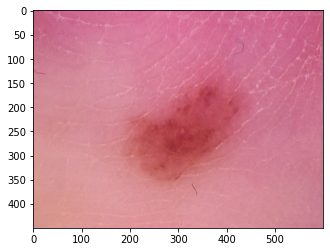

In [ ]:
import matplotlib.pyplot as plt
import cv2
b=cv2.imread('/content/dataset/ISIC_0024322.jpg')
b=cv2.cvtColor(b,cv2.COLOR_BGR2RGB)
plt.imshow(b)

## Paso 2: Transcribir los datos en un lenguaje que entienda el ordenador

Primero, vamos a introducir la información que conocemos acerca de las imágenes. Para ello vamos a utilizar la librería `pandas` que se especializa en introducir tablas de manera que sean fáciles de acceder y leer tanto por el ordenador, como por el usuario que lo maneja (https://pandas.pydata.org/).

In [ ]:
import os
import pandas as pd
df = pd.read_csv(os.path.join('HAM10000_metadata.csv'))

Una vez que hemos cargado la información, vamos a echarle un vistazo a las primeras entradas, para hacernos una idea de qué información tenemos y cómo está organizada.

In [ ]:
df.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


Nuestro objetivo es crear un modelo predictivo que a partir de una foto de una lesión nos diga cuál es el diagnóstico más probable. Por tanto, de esta tabla ahora mismo nos interesan fundamentalmente las columnas `image_id` que nos dice cuál es la foto a la que hace referencia y `dx` que refiere al diagnóstico de la enfermedad. 

Sin embargo nos encontramos con varios problemas de comunicación. Algunos nuestros y otros del ordenador que tendremos que subsanar.

1. La tabla tiene el código de identificación de la imagen, pero no sabe dónde encontrarla. Entonces, tenemos que darle un mapa al ordenador que le permita asociar código de imagen y localización dentro de su memoria.

2. El diagnóstico está escrito en un código tal que ni nosotros lo entendemos fácilmente, ni al ordenador le resulta fácil trabajar con él. Por tanto, tendremos que crear a) un mapa que nos permita traducir el código usado a un lenguaje que nosotros podamos comprender y b) otro mapa para que lo pueda entender el ordenador. 

### Problema 1: Mapa de código de imagen a localización de la imagen

La solución es conceptualmente sencilla, aunque el código resulta un poco complicado de entender si uno no está acostumbrado a la sintaxis de Python.

La idea es tomar el directorio en el que se encuentran las imágenes y para cada archivo dentro de él que termine en `.jpg` creamos una entrada en el mapa `imageid_path_dict` tal que a cada código de imagen, le corresponda la dirección completa.

In [ ]:
import os
from glob import glob
path_dataset='/content/dataset'
image_path_map = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(path_dataset,'*.jpg'))}
print(image_path_map)

{'ISIC_0028472': '/content/dataset/ISIC_0028472.jpg', 'ISIC_0029304': '/content/dataset/ISIC_0029304.jpg', 'ISIC_0033956': '/content/dataset/ISIC_0033956.jpg', 'ISIC_0033497': '/content/dataset/ISIC_0033497.jpg', 'ISIC_0029604': '/content/dataset/ISIC_0029604.jpg', 'ISIC_0025149': '/content/dataset/ISIC_0025149.jpg', 'ISIC_0027741': '/content/dataset/ISIC_0027741.jpg', 'ISIC_0034083': '/content/dataset/ISIC_0034083.jpg', 'ISIC_0032346': '/content/dataset/ISIC_0032346.jpg', 'ISIC_0032984': '/content/dataset/ISIC_0032984.jpg', 'ISIC_0032241': '/content/dataset/ISIC_0032241.jpg', 'ISIC_0032175': '/content/dataset/ISIC_0032175.jpg', 'ISIC_0032144': '/content/dataset/ISIC_0032144.jpg', 'ISIC_0031216': '/content/dataset/ISIC_0031216.jpg', 'ISIC_0029679': '/content/dataset/ISIC_0029679.jpg', 'ISIC_0027446': '/content/dataset/ISIC_0027446.jpg', 'ISIC_0031392': '/content/dataset/ISIC_0031392.jpg', 'ISIC_0027623': '/content/dataset/ISIC_0027623.jpg', 'ISIC_0034081': '/content/dataset/ISIC_003408

Una vez que hemos conseguido crear este mapa, lo utilizamos para añadir una nueva columna a la tabla anterior que contenga la dirección que le corresponde a cada imagen.

In [ ]:
df['path'] = df['image_id'].map(image_path_map.get)

### Problema 2: Mapas de diagnóstico para humanos y ordenadores

Este problema es más fácil de resolver. Creamos un mapa que para cada abreviatura de un diagnóstico nos diga si se corresponde con un tumor beningno o un cáncer maligno. Para que un humano lo interprete fácilmente utilizamos la palabra completa `Benign` o `Cancerous`; para que sea un ordenador el intérprete, sustituimos la palabra completa por un código de 1 o 0. Siendo 1 cáncer y 0 bening. 

In [ ]:
# making dictionary of labels
lesion_type_dict = {
    'nv': 'Bening',
    'mel': 'Cancerous',
    'bkl': 'Benign',
    'bcc': 'Cancerous',
    'akiec': 'Bening',
    'vasc': 'Bening',
    'df': 'Bening'
}
lesion_type_inv_map = {
    'nv': 0,
    'mel': 1,
    'bkl': 0,
    'bcc': 1,
    'akiec': 0,
    'vasc': 0,
    'df': 0

}
df.shape

(10015, 8)


Introducimos la nueva información como nuevas columnas en nuestra tabla

In [ ]:
df['Human Diagnosis'] = df['dx'].map(lesion_type_dict.get) 
df['Computer Diagnosis'] = df['dx'].map(lesion_type_inv_map.get)

Para verificar la cantidad de datos de cada una de las dos categorías podemos contar cuáles de las entradas pertenecen a cada uno de los dos grupos.

In [ ]:
bening = 0
cancerous = 0
for index, row in df.iterrows():
  if row['Computer Diagnosis'] == 0:
    bening += 1
  elif row['Computer Diagnosis'] == 1:
    cancerous += 1
print(bening, cancerous)

8388 1627


Comoo la base de datos está muy descompensada con muchos más ejemplos de benigno que maligno, la vamos a equilibrar eliminando un 80 % de las entradas de cáncer beningno.

In [ ]:
import random
import copy
for index, row in df.iterrows():
  if row['Computer Diagnosis'] == 0:
    if random.random() < 0.8:
      update_df = df.drop(index, axis=0)
      df = copy.copy(update_df)
df.shape

(3267, 10)

In [ ]:
bening = 0
cancerous = 0
for index, row in df.iterrows():
  if row['Computer Diagnosis'] == 0:
    bening += 1
  elif row['Computer Diagnosis'] == 1:
    cancerous += 1
print(bening, cancerous)

1640 1627


A continuación, comprobamos cómo ha quedado la tabla


In [ ]:
df.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,Human Diagnosis,Computer Diagnosis
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/dataset/ISIC_0026769.jpg,Benign,0
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,/content/dataset/ISIC_0027850.jpg,Benign,0
11,HAM_0004234,ISIC_0029396,bkl,histo,85.0,female,chest,/content/dataset/ISIC_0029396.jpg,Benign,0
15,HAM_0007207,ISIC_0031326,bkl,histo,65.0,male,back,/content/dataset/ISIC_0031326.jpg,Benign,0
24,HAM_0004884,ISIC_0025937,bkl,histo,75.0,male,upper extremity,/content/dataset/ISIC_0025937.jpg,Benign,0
26,HAM_0002521,ISIC_0029291,bkl,histo,40.0,male,upper extremity,/content/dataset/ISIC_0029291.jpg,Benign,0
42,HAM_0000164,ISIC_0026273,bkl,histo,60.0,male,chest,/content/dataset/ISIC_0026273.jpg,Benign,0
48,HAM_0007010,ISIC_0031691,bkl,histo,40.0,male,trunk,/content/dataset/ISIC_0031691.jpg,Benign,0
66,HAM_0004569,ISIC_0026104,bkl,histo,40.0,male,upper extremity,/content/dataset/ISIC_0026104.jpg,Benign,0
71,HAM_0004341,ISIC_0031967,bkl,histo,70.0,female,scalp,/content/dataset/ISIC_0031967.jpg,Benign,0


Finalmente, tenemos que asegurarnos de que no haya alguna entrada vacía que pueda provocar problemas luego.

In [ ]:
df.isnull().sum()

lesion_id              0
image_id               0
dx                     0
dx_type                0
age                   15
sex                    0
localization           0
path                   0
Human Diagnosis        0
Computer Diagnosis     0
dtype: int64

Hay varias entradas que no tienen edad. Nosotros no la vamos a utilizar para nada, por lo que _a priori_ no nos importa, pero como demostración de cómo se resolverían ese tipo de problemas vamos a tratar de solucionarlo. Existen 2 filosofías:

* Se eliminan las entradas vacías.
* Se rellenan con algún valor.

Escoger una u otra depende de cómo de relevante sea el factor que estamos estudiando, cuántas entradas se vean afectadas, etc.

Nosotros nos vamos a decantar por rellenar con un valor que en este caso será la mediana de todas las demás edades.

In [ ]:
df['age'].fillna((df['age'].median()), inplace=True)
df.isnull().sum()

lesion_id             0
image_id              0
dx                    0
dx_type               0
age                   0
sex                   0
localization          0
path                  0
Human Diagnosis       0
Computer Diagnosis    0
dtype: int64

Una última cosa que es interesante conocer es cuán grande es nuestra base de datos.

In [ ]:
df.shape

(3267, 10)

## Paso 3: Preparación de los datos para entrenar la red neural

Primero vamos a comprobar el tamaño de las imágenes. Para ello vamos a utilizar otras 2 librerías de Python:

* `numpy`: Especializada para trabajo con vectores y matrices (https://numpy.org/).
* `PIL`: Tratamiento de imágenes (https://pypi.org/project/Pillow/).

Vamos a crear una nueva columna en nuestra tabla que será para uso del ordenador. Esta columna contendrá 3 matrices con las intensidad de cada color RGB para cada pixel. Además, el programa se asegurará de que todas las matrices sean de tamaño 100x75. 

Como el programa va a tener que leer todas las imágenes y cargarlas en la tabla este paso va a llevar un ratín (2 min 30 s aprox).

In [ ]:
import numpy as np
from PIL import Image
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

A continuación, nos aseguramos que todas las imágenes tengan el tamaño que esperamos.

In [ ]:
df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    3267
Name: image, dtype: int64

Ahora, vamos a separar los datos en 2 subgrupos. El primer grupo y el más numeroso será el grupo de entrenamiento y el menos numeroso el de test. Para asegurarnos de estar tomando los datos de una manera homogénea y no estar introduciando sesgos en ninguno de los dos grupos utilizaremos una librería, `sklearn` que contiene funciones muy útiles para _machine learning_. Para ello definimos como atributos toda la información en la tabla menos las etiquetas.

In [ ]:
from sklearn.model_selection import train_test_split
features = df.drop(columns=["Computer Diagnosis"], axis=1)
target = df["Computer Diagnosis"]
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

Ahora reescribimos los atributos para contener solo las imágenes y normalizamos los valores para asegurarnos de que la iluminación al tomar la foto o factores similares no sesguen nuestros resultados.

In [ ]:
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_test_mean) / x_test_std

In [ ]:
"""from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes=1)
y_test = to_categorical(y_test, num_classes=1)"""

'from keras.utils.np_utils import to_categorical\ny_train = to_categorical(y_train, num_classes=1)\ny_test = to_categorical(y_test, num_classes=1)'

In [ ]:
y_test

8570    0
2736    1
9699    0
153     0
4847    0
       ..
9899    0
2501    1
1826    1
9007    0
7571    0
Name: Computer Diagnosis, Length: 654, dtype: int64

## Paso 4: Diseño de la red neural convolucional, entrenamiento y validación

Dentro del entrenamiento crearemos un subset de validación para asegurarnos de cómo va progresando cada paso del entrenamiento. Para ello dividiremos los datos una vez más.

In [ ]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=0.2)

Definimos el tamaño de cada imagen para que la red neural entienda que son 3 colores.

In [ ]:
x_train = x_train.reshape(x_train.shape[0], *(100,75,3))
x_test = x_test.reshape(x_test.shape[0], *(100,75,3))
x_validate = x_validate.reshape(x_validate.shape[0], *(100,75,3))

Creamos la red neural utilizando la librería tensorflow (https://www.tensorflow.org/). Los diferentes tipos de capas que se pueden utilizar los encontramos en el siguiente enlace (https://www.tensorflow.org/api_docs/python/tf/keras/layers).

In [ ]:
import tensorflow as tf

In [ ]:
input_shape = (100, 75, 3)
num_classes = 1

model = tf.keras.Sequential(layers=
(
  # Convolutional Layer
  tf.keras.layers.Conv2D(32, kernel_size=(3,3),input_shape=input_shape, 
                         activation='relu', padding ='valid'),
  tf.keras.layers.MaxPool2D(pool_size=(2,2)),

  # Dropout
  tf.keras.layers.Dropout(0.2),

  # Flatten
  tf.keras.layers.Flatten(),
  # Dense layer
  tf.keras.layers.Dense(64, activation='relu'),

  # Output layer
  tf.keras.layers.Dense(num_classes, activation='sigmoid')
))
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 98, 73, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 49, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 47, 34, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 23, 17, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 21, 15, 32)        9248      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 10, 7, 32)       

En el output anterior podemos ver la forma de los outputs de cada una de las capas y el número de parametros que cada habría que entrenar en cada capa. Es importante considerar que el número de _Trainable params_ final debería ser como máximo 10 veces menos que el número de atributos en nuestro dataset de entrenamiento. En nuestro caso tenemos 100x75x3 atributos por cada imagen, tenemos 3.000 imágenes en el dataset de entrenamiento. Por tanto, tenemos un total de 67.500.000. Nuestra red pues no debe contar con más de 6.750.000 parámetros (10 veces menos) y lo ideal sería que tuviese menos de 675.000 (100 veces menos). Así cada parámetros "dispone" de 100 atributos con los que entrenarse.

El siguiente paso será compilar el modelo, para lo cual tenemos que definir el algoritmo de optimización, la función de pérdida y las métricas que nos interesan. 

El fundamento teórico detrás de los algoritmos de optimzación y de las funciones de pérdida está muy por encima de los objetivos de este taller ya que requieren un conocimiento bastante avanzado de cálculo numérico, algoritmia y estadística.

De una manera muy simple, en general se suele utilizar como algoritmo de optimización `Adam` para la mayoría de usos por presentar una gran eficiencia computacional y ser  estable. Por su parte, las función de pérdida suelen depender del campo de la ciencia en que nos encontremos y como se comporten nuestros datos, pero las funciones de la familia de entropía cruzada son las más comunes y, a falta de información más específica acerca de la distribución de nuestros datos, son las más indicadas. En este caso, como tenemos 2 posibles outputs, vamos a utilizar la función de pérdida `binary_crossentropy`


In [ ]:
model.compile(optimizer='adam' , loss="binary_crossentropy", metrics=["accuracy"])

A continuación, preparamos las imagenes para la entrada en la red neural. Además, augmentamos el dataset introduciendo copias de las imagenes con ligeras rotaciones, zoom, movimientos laterales,  así como imagenes especulares en el eje horizontal y en el vertical. Esto permite eliminar sobreajuste al incrementar la diversidad del dataset.

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10, 
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,  
        horizontal_flip=True,  
        vertical_flip=True)  
datagen.fit(x_train, augment=True)



Ahora entrenamos la red neural. Por motivos de tiempo vamos a entrenarla solamente por 50 _epochs_. Aún con el modelo simplicado que estamos utilizando este paso tardará aproximadamente 5 min (30s/epoch). 

In [ ]:
epochs = 50
batch_size = 10
history = model.fit(datagen.flow(x_train, y_train,batch_size=batch_size),
                    epochs=epochs, 
                    validation_data=(x_validate,y_validate),
                    verbose=2, 
                    steps_per_epoch=x_train.shape[0]//batch_size)

Epoch 1/100
209/209 - 6s - loss: 0.6374 - accuracy: 0.6301 - val_loss: 0.6144 - val_accuracy: 0.6558 - 6s/epoch - 31ms/step
Epoch 2/100
209/209 - 5s - loss: 0.5977 - accuracy: 0.6742 - val_loss: 0.5782 - val_accuracy: 0.6750 - 5s/epoch - 25ms/step
Epoch 3/100
209/209 - 5s - loss: 0.5733 - accuracy: 0.6861 - val_loss: 0.5683 - val_accuracy: 0.6864 - 5s/epoch - 26ms/step
Epoch 4/100
209/209 - 5s - loss: 0.5706 - accuracy: 0.6990 - val_loss: 0.5612 - val_accuracy: 0.6941 - 5s/epoch - 26ms/step
Epoch 5/100
209/209 - 5s - loss: 0.5567 - accuracy: 0.6933 - val_loss: 0.5673 - val_accuracy: 0.6902 - 5s/epoch - 26ms/step
Epoch 6/100
209/209 - 5s - loss: 0.5540 - accuracy: 0.6990 - val_loss: 0.5850 - val_accuracy: 0.6539 - 5s/epoch - 25ms/step
Epoch 7/100
209/209 - 5s - loss: 0.5632 - accuracy: 0.6947 - val_loss: 0.5573 - val_accuracy: 0.6998 - 5s/epoch - 26ms/step
Epoch 8/100
209/209 - 5s - loss: 0.5533 - accuracy: 0.7019 - val_loss: 0.5815 - val_accuracy: 0.6692 - 5s/epoch - 26ms/step
Epoch 9/

# Análisis de los resultados

## Pregunta 1: ¿Hay sobreajuste?

Para comprobar si hay sobreajuste uno de los análisis más sencillos que podemos realizar es comprobar cómo ha evolucionado el aprendizaje de la red y como tras cada nueva ronda de aprendizaje (_epoch_) va cambiando su evaluación.

Text(0.5, 1.0, 'Training and validation loss')

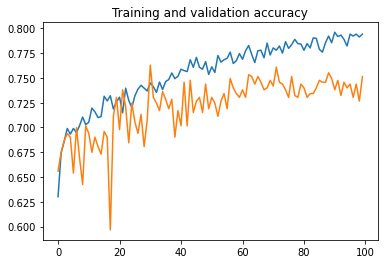

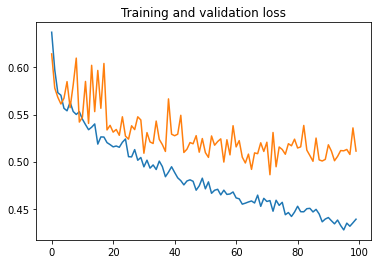

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss' ]
val_loss = history.history['val_loss']

epochs = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot( epochs,     acc )
plt.plot( epochs, val_acc )
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

## Pregunta 2: ¿Cómo predice nuestro modelo tipos de cáncer?

Para valorar cómo está discriminando la red la importancia de las diferentes características, podemos examinar los _outputs_ de las diferentes capas de convolución.

['/content/dataset/ISIC_0028472.jpg', '/content/dataset/ISIC_0029304.jpg', '/content/dataset/ISIC_0033956.jpg', '/content/dataset/ISIC_0033497.jpg', '/content/dataset/ISIC_0029604.jpg', '/content/dataset/ISIC_0025149.jpg', '/content/dataset/ISIC_0027741.jpg', '/content/dataset/ISIC_0034083.jpg', '/content/dataset/ISIC_0032346.jpg', '/content/dataset/ISIC_0032984.jpg', '/content/dataset/ISIC_0032241.jpg', '/content/dataset/ISIC_0032175.jpg', '/content/dataset/ISIC_0032144.jpg', '/content/dataset/ISIC_0031216.jpg', '/content/dataset/ISIC_0029679.jpg', '/content/dataset/ISIC_0027446.jpg', '/content/dataset/ISIC_0031392.jpg', '/content/dataset/ISIC_0027623.jpg', '/content/dataset/ISIC_0034081.jpg', '/content/dataset/ISIC_0030395.jpg', '/content/dataset/ISIC_0030554.jpg', '/content/dataset/ISIC_0029045.jpg', '/content/dataset/ISIC_0024660.jpg', '/content/dataset/ISIC_0033108.jpg', '/content/dataset/ISIC_0033681.jpg', '/content/dataset/ISIC_0027654.jpg', '/content/dataset/ISIC_0031251.jpg', 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


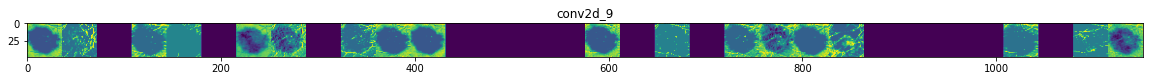

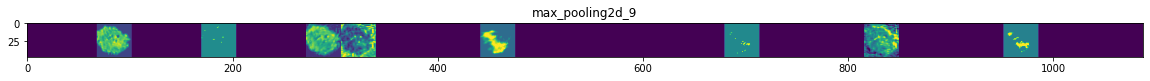

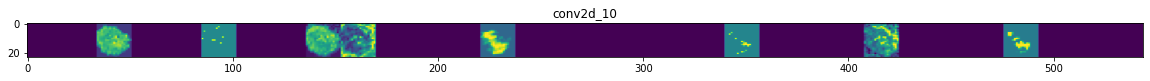

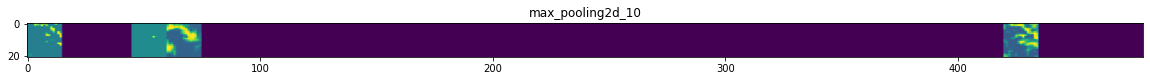

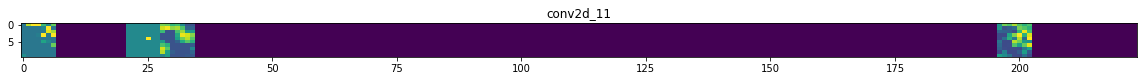

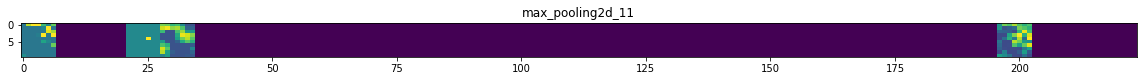

In [ ]:
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
images = list()
for x in os.listdir(path_dataset):
  images.append(path_dataset + "/" + x) 
img_path = random.choice(images)
img = load_img(img_path, target_size=(100, 75))  # this is a PIL image
x   = img_to_array(img)                           # Numpy array with shape (100, 75, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 100, 75, 3)

# Rescale by 1/255
x /= 255.0
# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size1       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    size2       = feature_map.shape[ 2]  # feature map shape (1, size, size, n_features)

    
    # We will tile our images in this matrix
    display_grid = np.zeros((size1, size2 * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size2 : (i + 1) * size2] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

## Pregunta 3: Validación Final

Una vez el modelo ha sido entrenado llega el momento de validarlo contra el test dataset. Esta validación no se debe realizar hasta el último momento del proceso, justo antes de lanzar el modelo final. En nuestro caso, podemos intentarlo ahora. También es importante antes de realizar el test marcar un valor a partir del cual nuestro modelo es útil y por tanto lo publicaremos o no lo es y por tanto volveremos a empezar. Sería necesario conseguir nuevos datos que no hayamos usado nunca para el test dataset.

En este caso podemos poner como valor 0.75 de precisión, que significaría que de 3 de cada 4 veces el modelo diagnostica correctamente un cáncer de piel.

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

Test: accuracy = 0.737003  ;  loss = 0.508799
